# Exploratoy Data Analysis

## Imports

In [2]:
import pandas as pd
import sqlite3
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

## Connection with the database

In [3]:
DB_PATH = Path("../data/olist.db")
conn = sqlite3.connect(DB_PATH)

## Control querys

In [4]:
query = """
SELECT COUNT(*) AS total_orders
FROM fact_orders;"""

df = pd.read_sql(query, conn)

df

,total_orders
0,96478


In [5]:
query2 = """
SELECT COUNT(*) 
FROM olist_orders_dataset
WHERE order_status = 'delivered';
"""

df2 = pd.read_sql(query2, conn)

df2

,COUNT(*)
0,96478


we did not loose any order or have duplicates.

In [6]:
query = """
SELECT order_id, COUNT(*) AS cnt
FROM fact_orders
GROUP BY order_id
HAVING COUNT(*) > 1;
"""

pd.read_sql(query, conn)

,order_id,cnt


return void like we wanted.

## Revenue vs. Payments

In [7]:
query = """
SELECT 
    COUNT(*) AS total_orders,
    SUM(order_revenue) AS total_revenue,
    SUM(total_paid) AS total_paid
FROM fact_orders;
"""

df = pd.read_sql(query, conn)

df

,total_orders,total_revenue,total_paid
0,96478,1.541977e+07,1.542246e+07


In [8]:
query = """ 
SELECT
    COUNT(*) AS total_orders,
    SUM(CASE WHEN ABS(order_revenue - total_paid) > 0 THEN 1 ELSE 0 END) AS orders_with_gap
FROM fact_orders;
"""

df_gaps = pd.read_sql(query, conn)

df_gaps

,total_orders,orders_with_gap
0,96478,19320


There are 19320 orders that the payment is lower than the order revenue. 

### Veamoslo dividiendo los datos por mes

In [9]:
query = """
SELECT
    strftime('%Y-%m', date) AS year_month,
    SUM(order_revenue) AS theoretical_revenue,
    SUM(total_paid) AS actual_revenue
    FROM fact_orders
    GROUP BY year_month
    ORDER BY year_month;
"""

df_rev = pd.read_sql(query, conn)



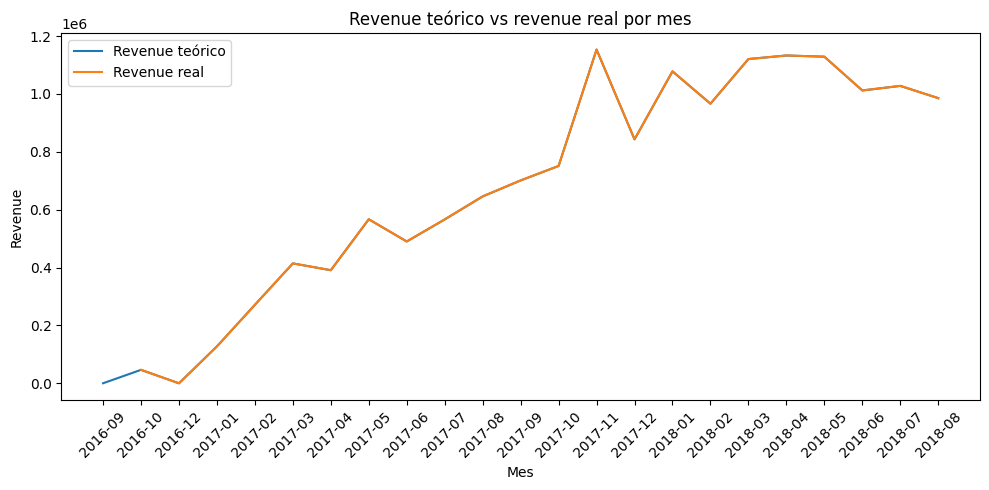

In [10]:
plt.figure(figsize=(10,5))

plt.plot(df_rev["year_month"], df_rev["theoretical_revenue"], label="Revenue teórico")
plt.plot(df_rev["year_month"], df_rev["actual_revenue"], label="Revenue real")

plt.xticks(rotation=45)
plt.xlabel("Mes")
plt.ylabel("Revenue")
plt.title("Revenue teórico vs revenue real por mes")
plt.legend()
plt.tight_layout()
plt.show()

Gráficamente no llega a ser significativo esas diferencias entre los pagos esperados y los pagos reales.

## Temporaly evolution of the business.

In [11]:
query = """
SELECT
    strftime('%Y-%m', date) AS year_month,
    COUNT(*) AS orders,
    SUM(total_paid) AS revenue
FROM fact_orders
WHERE total_paid IS NOT NULL
GROUP BY year_month
ORDER BY year_month;
"""


df_monthly = pd.read_sql(query, conn)


* Monthly revenue:

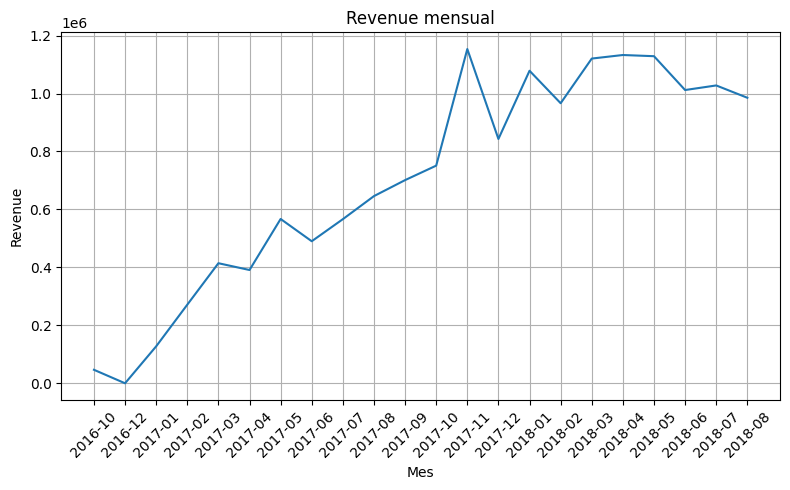

In [12]:
plt.figure(figsize=(8,5))
plt.plot(df_monthly["year_month"], df_monthly["revenue"])
plt.xticks(rotation=45)
plt.title("Revenue mensual")
plt.xlabel("Mes")
plt.ylabel("Revenue")
plt.tight_layout()
plt.grid()
plt.show()

Notamos que la tendencia es que el revenue aumenta de acuerdo al tiempo. No es algo lineal, sino que por momentos puede decrecer pero a la larga "recupera" lo perdido.

* Monthly orders

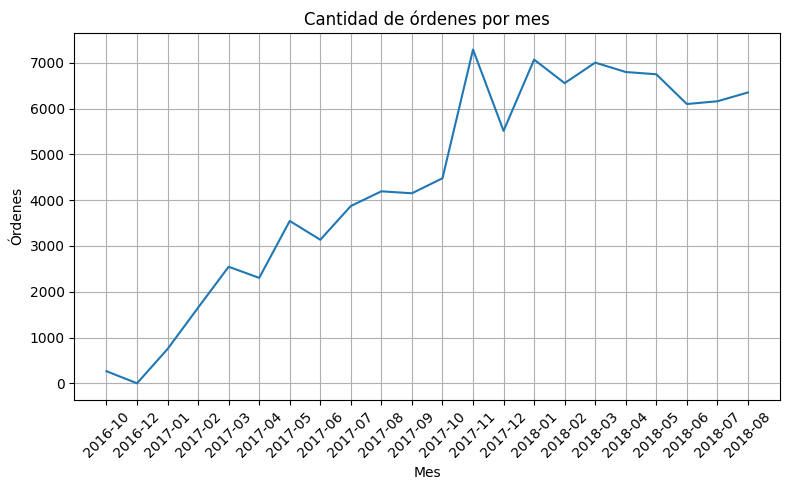

In [13]:
plt.figure(figsize=(8,5))
plt.plot(df_monthly["year_month"], df_monthly["orders"])
plt.xticks(rotation=45)
plt.title("Cantidad de órdenes por mes")
plt.xlabel("Mes")
plt.ylabel("Órdenes")
plt.tight_layout()
plt.grid()
plt.show()

Se gráfica una curva similar a la de tiempo vs revenue. Tiene sentido ya que hay relación entre la cantidad de ordenes y el total pagado.

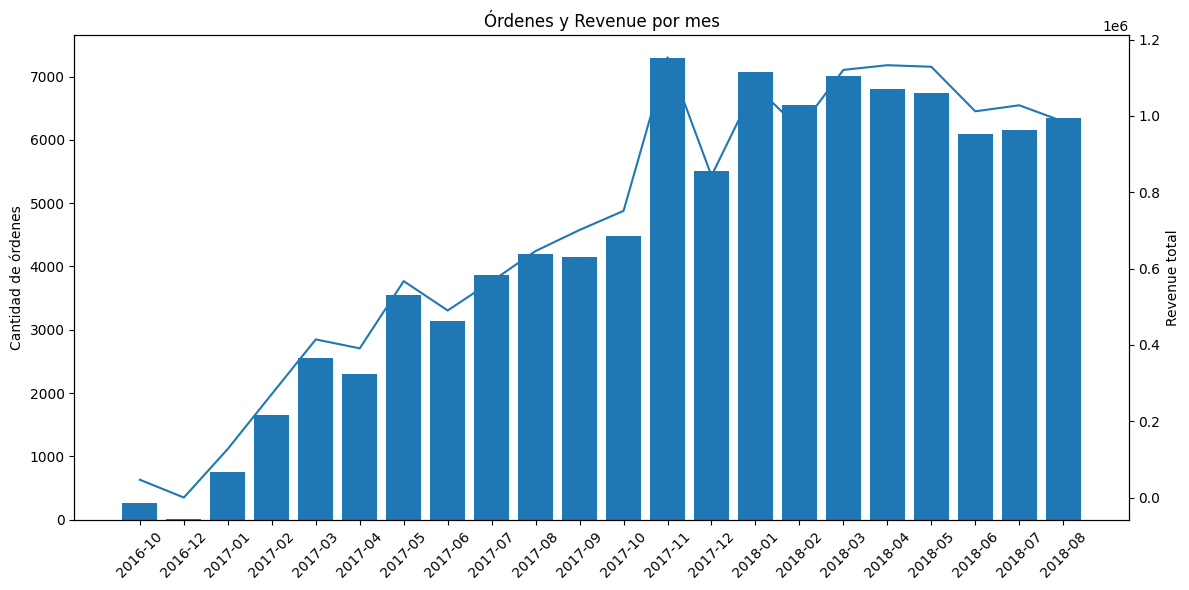

In [38]:
fig, ax1 = plt.subplots(figsize=(12,6))

ax1.bar(df_monthly["year_month"], df_monthly["orders"])
ax1.set_ylabel("Cantidad de órdenes")

plt.xticks(rotation=45)

ax2 = ax1.twinx()
ax2.plot(df_monthly["year_month"], df_monthly["revenue"])
ax2.set_ylabel("Revenue total")

plt.title("Órdenes y Revenue por mes")

plt.tight_layout()
plt.show()

Mismos gráficos que antes pero en un doble eje.

## Payment method's distribution

In [14]:
query = """
SELECT
    payment_types,
    COUNT(*) AS orders,
    SUM(total_paid) AS revenue
FROM fact_orders
WHERE total_paid IS NOT NULL
GROUP BY payment_types
ORDER BY revenue DESC;
"""


df_ptypes = pd.read_sql(query, conn)

Tuve que agregar esta linea `WHERE total_paid IS NOT NULL` para poder realizar el gráfico.

In [15]:
query = """
SELECT
    COUNT(*) AS order_null
FROM fact_orders
WHERE total_paid IS NULL;
"""

df_nulls = pd.read_sql(query, conn)

df_nulls

,order_null
0,1


Se encontro una orden cuyo pago total es NULL.

Ahora si, procedemos a realizar el gráfico.

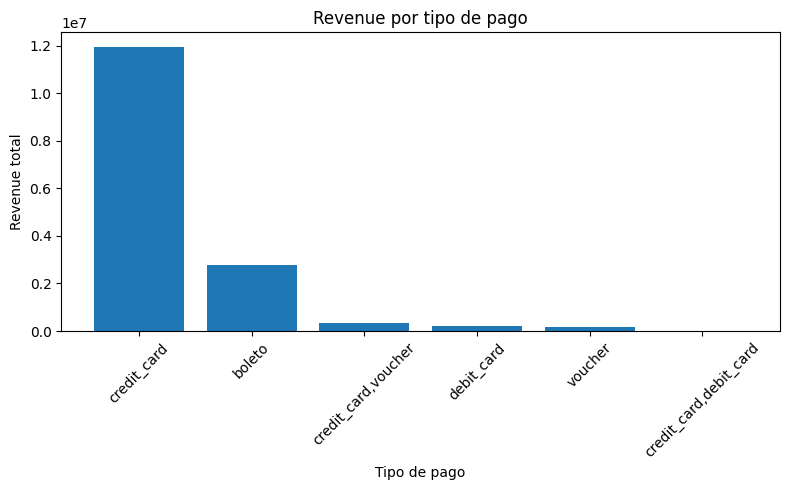

In [16]:
plt.figure(figsize=(8,5))

plt.bar(df_ptypes["payment_types"], df_ptypes["revenue"])

plt.title("Revenue por tipo de pago")
plt.xlabel("Tipo de pago")
plt.ylabel("Revenue total")

plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

Se observa que el tipo de pago con el que se pagaron mayores montos es `credit_card` por amplia diferencia.

También es interesante realizar un gráfico de barras pero que el eje Y sea la cantidad de ordenes.

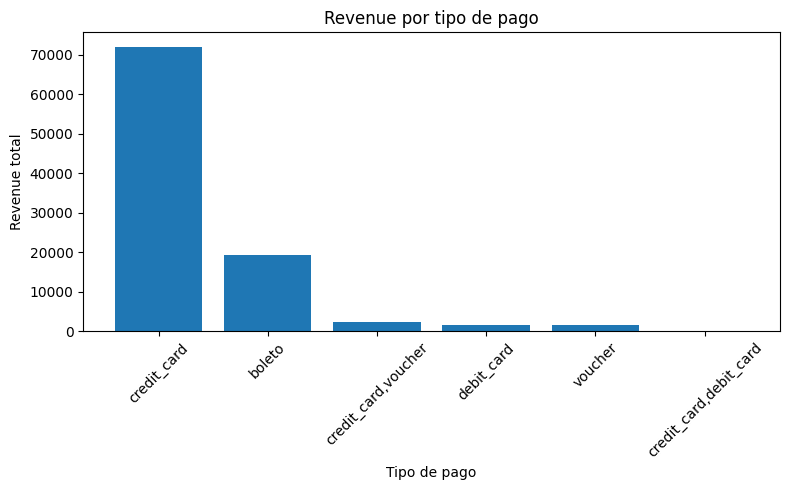

In [17]:
plt.figure(figsize=(8,5))

plt.bar(df_ptypes["payment_types"], df_ptypes["orders"])

plt.title("Revenue por tipo de pago")
plt.xlabel("Tipo de pago")
plt.ylabel("Revenue total")

plt.xticks(rotation=45)
plt.tight_layout()


plt.show()

Como es esperado el gráfico es similar al de revenue.

## Geographic analysis

In [18]:
query = """
SELECT 
    customer_state,
    SUM(total_paid) AS revenue,
    AVG(total_paid) AS avg_ticket,
    COUNT(*) AS orders
FROM fact_orders
GROUP BY customer_state
ORDER BY revenue DESC; 
"""


df_geo = pd.read_sql(query, conn)

### State vs Revenue

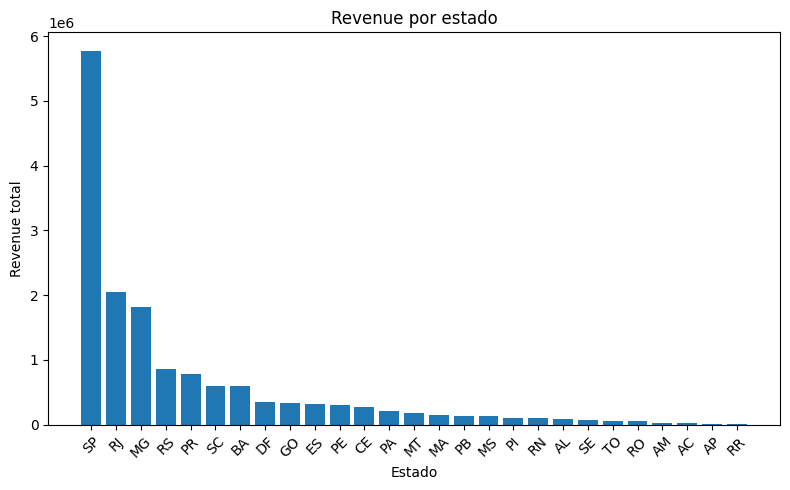

In [19]:
plt.figure(figsize=(8,5))

plt.bar(df_geo["customer_state"], df_geo["revenue"])

plt.title("Revenue por estado")
plt.xlabel("Estado")
plt.ylabel("Revenue total")

plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

Se observa que el estado en el que más dinero se recauda, por amplia diferencia, es San Pablo.

### State vs Average ticket

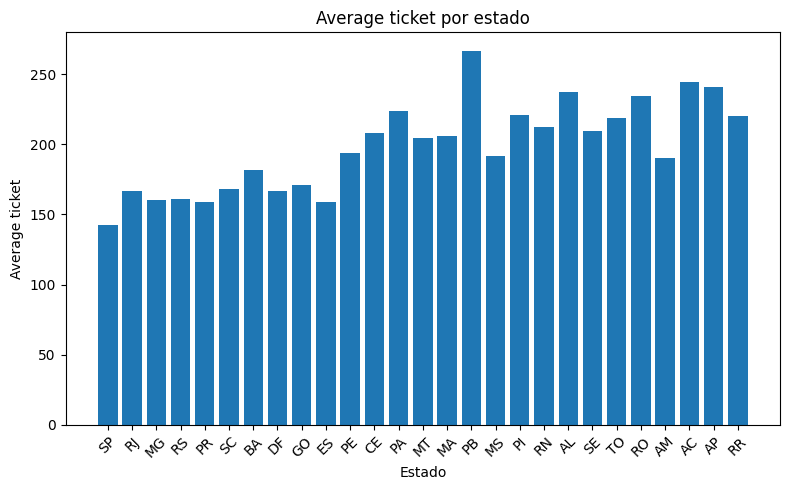

In [20]:
plt.figure(figsize=(8,5))

plt.bar(df_geo["customer_state"], df_geo["avg_ticket"])

plt.title("Average ticket por estado")
plt.xlabel("Estado")
plt.ylabel("Average ticket")

plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

Notamos que no necesariamente el estado que más dinero recauda es el que tiene el ticket más alto. Sin embargo, el promedio de los ticketes está equilibrado.

## Ticket promedio y distribución

In [21]:
query = """
SELECT total_paid
FROM fact_orders
WHERE total_paid IS NOT NULL;
"""

df_totPaid = pd.read_sql(query, conn)

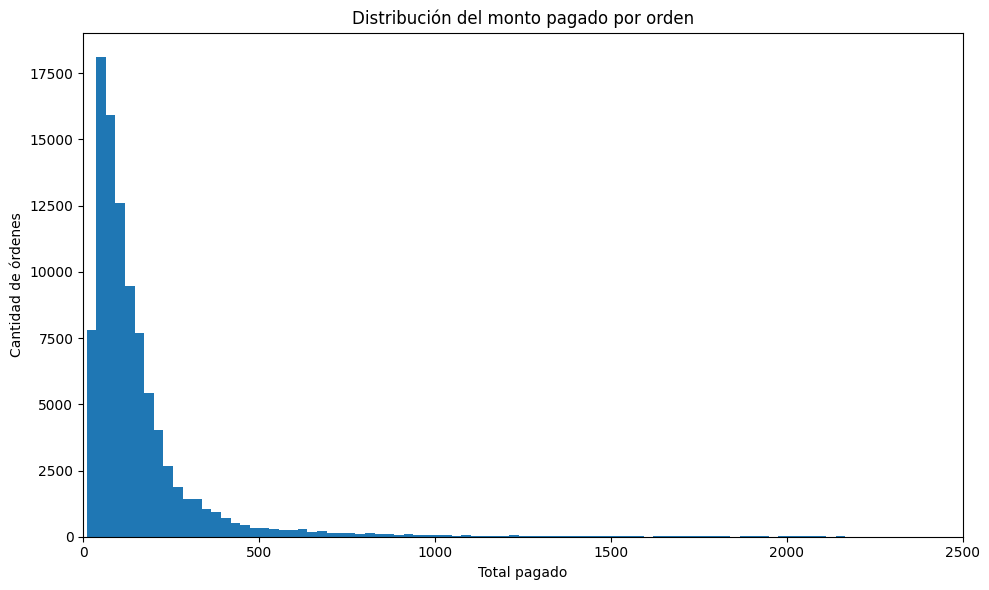

In [22]:
plt.figure(figsize=(10,6))

plt.hist(df_totPaid["total_paid"], bins=500)
plt.xlim(right = 2500, left = 0)
#plt.xscale("log")

plt.title("Distribución del monto pagado por orden")
plt.xlabel("Total pagado")
plt.ylabel("Cantidad de órdenes")

plt.tight_layout()
plt.show()

In [23]:
df_totPaid["total_paid"].describe()

count    96477.000000
mean       159.856357
std        218.813144
min          9.590000
25%         61.880000
50%        105.280000
75%        176.330000
max      13664.080000
Name: total_paid, dtype: float64

Observamos en el histograma que la distribución es de cola alargada y sesgada a la derecha. Vamos a tratar de aproximar por alguna distribución conocida.

* Veamos el logaritmo...

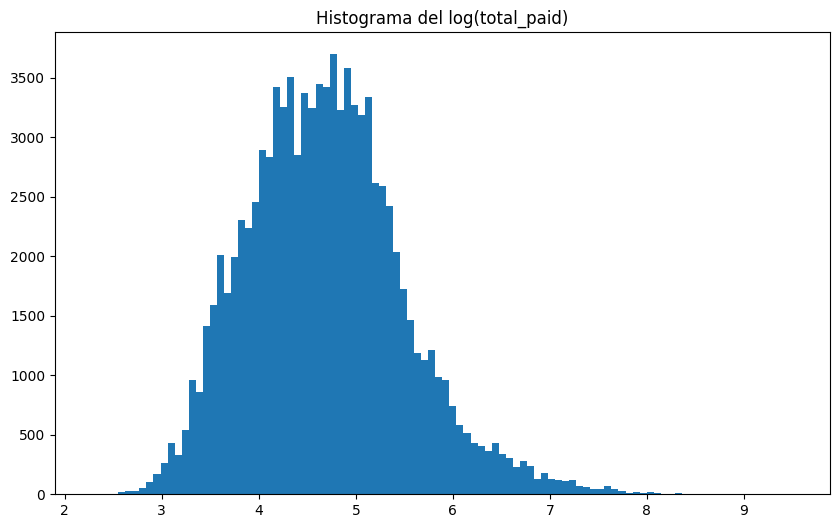

In [24]:
plt.figure(figsize=(10,6))
plt.hist(np.log(df_totPaid["total_paid"]), bins=100)
plt.title("Histograma del log(total_paid)")
plt.show()

A ojo se podría decir que esto tiene un aspecto normal.

### QQ-plot

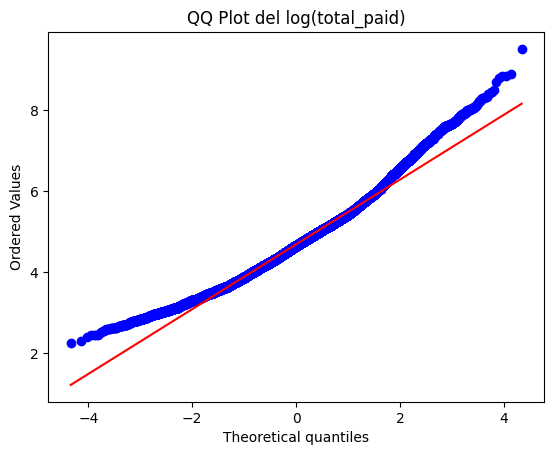

In [25]:
stats.probplot(np.log(df_totPaid["total_paid"]), dist="norm", plot=plt)
plt.title("QQ Plot del log(total_paid)")
plt.show()

El QQ plot del log(total_paid) muestra buen ajuste en la región central pero desviaciones en las colas, indicando presencia de colas pesadas y valores extremos frecuentes, comportamiento típico en distribuciones de gasto en ecommerce.

## Delivery time

In [27]:
query = """
SELECT 
    date,
    order_delivered_customer_date
FROM fact_orders
WHERE order_delivered_customer_date IS NOT NULL;
"""

df_delivery = pd.read_sql(query, conn)

* transform dates:

In [28]:
df_delivery["date"] = pd.to_datetime(df_delivery["date"])

df_delivery["order_delivered_customer_date"] = pd.to_datetime(
    df_delivery["order_delivered_customer_date"])

* create feature delivery time:

In [29]:
df_delivery["delivery_days"] = (
    df_delivery["order_delivered_customer_date"] -
    df_delivery["date"]
).dt.days

df_delivery["delivery_days"].describe()

count    96470.000000
mean        12.093604
std          9.551380
min          0.000000
25%          6.000000
50%         10.000000
75%         15.000000
max        209.000000
Name: delivery_days, dtype: float64

* Clean outliers

In [30]:
df_delivery = df_delivery[
    (df_delivery["delivery_days"] >= 0) &
    (df_delivery["delivery_days"] <= 60)
]

* Histogram:

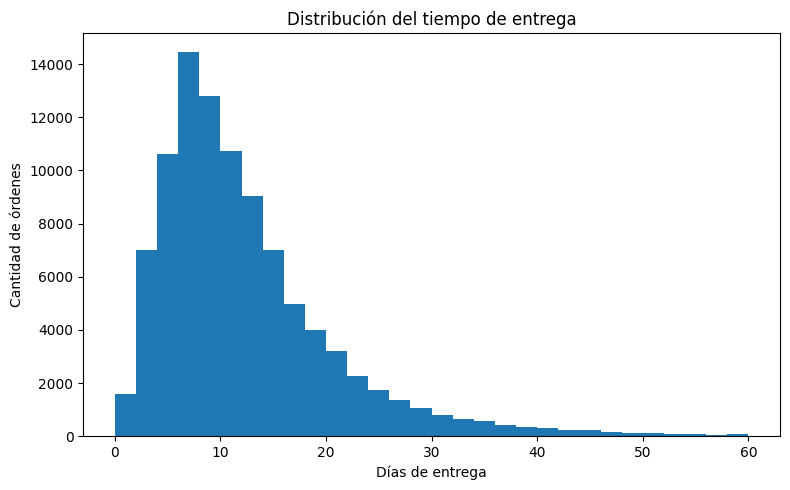

In [31]:
plt.figure(figsize=(8,5))

plt.hist(df_delivery["delivery_days"], bins=30)

plt.title("Distribución del tiempo de entrega")
plt.xlabel("Días de entrega")
plt.ylabel("Cantidad de órdenes")

plt.tight_layout()
plt.show()

Observamos que la mayor parte de los pedidos se entregan en un rango de 6 a 15 días.

### Tiempo de entrega por estado.

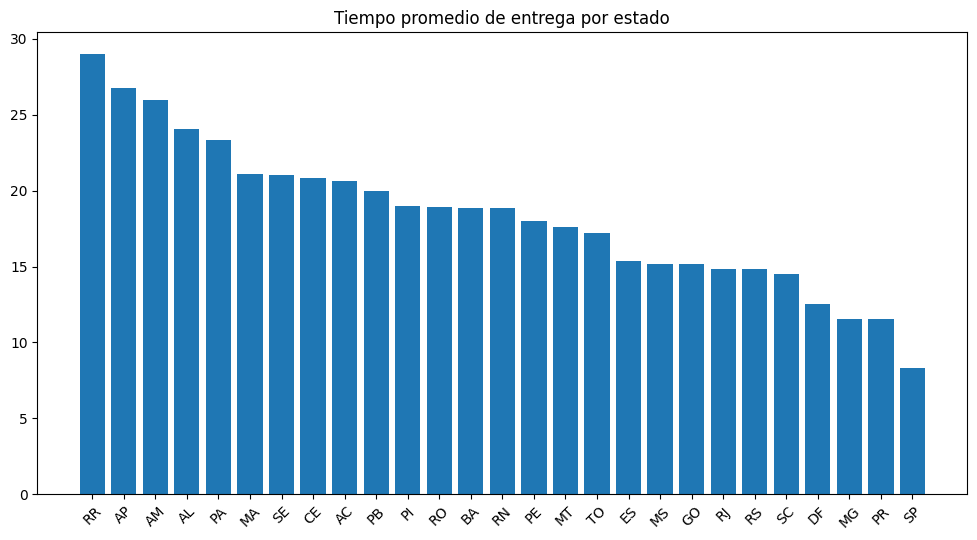

In [32]:
query = """
SELECT
    customer_state,
    date,
    order_delivered_customer_date
FROM fact_orders
WHERE order_delivered_customer_date IS NOT NULL
"""

df_state = pd.read_sql_query(query, conn)

df_state["date"] = pd.to_datetime(df_state["date"])
df_state["order_delivered_customer_date"] = pd.to_datetime(
    df_state["order_delivered_customer_date"]
)

df_state["delivery_days"] = (
    df_state["order_delivered_customer_date"] -
    df_state["date"]
).dt.days

avg_delivery = (
    df_state.groupby("customer_state")["delivery_days"]
    .mean()
    .sort_values(ascending=False)
)

plt.figure(figsize=(12,6))
plt.bar(avg_delivery.index, avg_delivery.values)

plt.title("Tiempo promedio de entrega por estado")
plt.xticks(rotation=45)

plt.show()


Observamos que el estado que menos tiempo se tarda en promedio en San Pablo que a su vez el que más ordenes tiene. A su vez el que menos ordenes tiene es en el que más tiempo se tarda.